In [3]:
# import all important libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px


## Loading the datasets

Dataset sourced from : https://docs.google.com/spreadsheets/d/1v13CZX8nUOkNbR3p3Dgj8c-sbP39dtGF-rbXKchj_fg/edit?gid=0#gid=0



Notebook wide filters

In [4]:
# Notebook wide filters

year_filter = ['2008','2012','2016','2020']
state_filter = ['PA','WI','FL','NY']



Static lookups

In [5]:
# lookups

# county classifcation

rucc_to_category = {
    1: "Urban",         # Metro: 1+ million population
    2: "Semi-Urban",         # Metro: 250,000 - 1 million population
    3: "Semi-Urban",         # Metro: <250,000 population
    4: "Rural",         # Adjacent to metro, >20,000 urban population
    5: "Rural",         # Adjacent to metro, 2,500 - 19,999 urban population
    6: "Rural",    # Adjacent to metro, <2,500 urban population
    7: "Rural",    # Non-adjacent to metro, >20,000 urban population
    8: "Rural",         # Non-adjacent to metro, 2,500 - 19,999 urban population
    9: "Rural"          # Non-adjacent to metro, <2,500 urban population
}

# State FIPS to state PO
fips_to_state_po = {
    "01": "AL",
    "02": "AK",
    "04": "AZ",
    "05": "AR",
    "06": "CA",
    "08": "CO",
    "09": "CT",
    "10": "DE",
    "11": "DC",
    "12": "FL",
    "13": "GA",
    "15": "HI",
    "16": "ID",
    "17": "IL",
    "18": "IN",
    "19": "IA",
    "20": "KS",
    "21": "KY",
    "22": "LA",
    "23": "ME",
    "24": "MD",
    "25": "MA",
    "26": "MI",
    "27": "MN",
    "28": "MS",
    "29": "MO",
    "30": "MT",
    "31": "NE",
    "32": "NV",
    "33": "NH",
    "34": "NJ",
    "35": "NM",
    "36": "NY",
    "37": "NC",
    "38": "ND",
    "39": "OH",
    "40": "OK",
    "41": "OR",
    "42": "PA",
    "44": "RI",
    "45": "SC",
    "46": "SD",
    "47": "TN",
    "48": "TX",
    "49": "UT",
    "50": "VT",
    "51": "VA",
    "53": "WA",
    "54": "WV",
    "55": "WI",
    "56": "WY",
    "72": "PR"  # Puerto Rico
}

Loading the datasets using google drive links

In [6]:
def load_data(file_link):
  direct_url = f'https://drive.google.com/uc?id={file_link}'
  df_loaded = pd.read_csv(direct_url)
  return(df_loaded)


## Functions for data prep and transformations (Use doctring for descriptions)

Adding county level FIPS & year to string

In [7]:
def add_county_fips(df_input,fips_column_name):
  """ Functions adds FIPS column for a county"""
  df_copy = df_input.copy()
  df_copy[fips_column_name] = df_copy[fips_column_name].astype(int).round(0).astype(str).str.zfill(5)

  return df_copy

def add_county_fips_p2(df_input,fips_column_name,year):
  """ Functions adds FIPS column for a county & converts year to text"""
  df_copy = df_input.copy()
  df_copy[fips_column_name] = df_copy[fips_column_name].apply(lambda x: str(x).split('.')[0]).astype(str).str.zfill(5)
  df_copy[year] = df_copy[year].astype(str)

  return df_copy

def add_state_fips(df_input,fips_column_name,fips_new_column,year):
  """ Functions adds FIPS column for a state"""
  df_copy = df_input.copy()
  df_copy[fips_new_column] = df_copy[fips_column_name].astype(str).str.zfill(2)
  df_copy[year] = df_copy[year].astype(str)
  return df_copy

def add_state_fips_p2(df_input,fips_column_name,year):
  """ Functions adds FIPS column for a state"""
  df_copy = df_input.copy()
  df_copy[fips_column_name] = df_copy[fips_column_name].astype(str).str.zfill(2)
  df_copy[year] = df_copy[year].astype(str)
  return df_copy

def yr_to_str(df_input,year):
  """ Function converts year to string format"""
  df_copy = df_input.copy()
  df_copy[year] = df_copy[year].astype(str)
  return df_copy

In [8]:
def basic_transformations(df_input):
  """ Functions adds FIPS column for a state"""
  df_copy = df_input.copy()

In [9]:
def prep_economic_indicator_data(df_input,df_input_1,year_filter,state_filters,fips_to_state_po):

  """ Functions preps economic indicators at a state level"""
  df_copy = df_input.copy()
  df_copy_1 = df_input_1.copy()

  # filtering the employment for 2008 onwards

  conditions = (df_copy['Year'] >= '2008')
  df_copy = df_copy[conditions]



  # adding un-employment metrics

  df_copy['total_unemployed'] = df_copy['Male Unemployed'] + df_copy['Female Unemployed']
  df_copy['total_labor'] = df_copy['Female Labor Force'] + df_copy['Male Labor Force']
  df_copy['unemployment_rate'] = round(df_copy['total_unemployed']/df_copy['total_labor']*100,2)

  df_copy['state_po'] = df_copy['state_fips'].map(fips_to_state_po)

  # adding CPI index to un-employed metics

  df_copy_2 = pd.merge(df_copy, df_copy_1, left_on = ['Year'], right_on = ['year'], how = 'left')

  # calculating inflation adjusted median household income (Year 2008 as base)

  cpi_2008 = df_copy_1[df_copy_1['year'] == '2008']['cpi_index'].values[0]

  df_copy_2['adjusted_median_income'] = round(df_copy_2['Median Household Income'] * (cpi_2008/df_copy_2['cpi_index']),2)

  # filter income_unemployment(state filter - notebook wide)

  df_copy_2 = df_copy_2[df_copy_2['state_po'].isin(state_filter)]

  return df_copy_2


In [10]:
def state_level_vote_share(df_input,year_filter,state_filters,political_party):
  """ Functions preps vote share at a state level | Filters for notebook wide year and state filter"""
  df_copy = df_input.copy()

  # filtering the state level vote share data for 1.) Filter states & election years 2.) Democrats

  conditions = (df_copy['party_simplified'] == political_party) & (df_copy['year'].isin(year_filter)) & (df_copy['state_po'].isin(state_filter))
  state_vote_share_party = df_copy[conditions].reset_index()

  # adding the vote share perc
  state_vote_share_party['vote_share'] = round(state_vote_share_party['candidatevotes']*100/state_vote_share_party['totalvotes'],2)

  return state_vote_share_party

In [11]:
def county_level_data(df_input , df_input_1 , selected_party , state_filter , year_filter , rucc_to_category):
  """ Functions preps data at county level | filter for states , election year and party | classfies rural urban"""

  df_copy = df_input.copy()
  df_copy_1 = df_input_1.copy()

  conditions = (df_copy['party'] == selected_party) & (df_copy['year'].isin(year_filter)) & (df_copy['state_po'].isin(state_filter))
  state_vote_share_democrats = df_copy[conditions]

  df_vote_share_trans_1 = state_vote_share_democrats.merge(df_copy_1, left_on = ['county_fips'], right_on =['FIPS'],how = 'left' )

  # classifying county as urban .....

  df_vote_share_trans_1['Urban_rural_classification'] = df_vote_share_trans_1['RUCC_2013'].map(rucc_to_category)

  return df_vote_share_trans_1

In [12]:
def agg_county_level_data(df_input):
  """ Agg county level data | year , state , urban rural classification level"""
  df_copy = df_input.copy()


  # agg vote share (on a urban rural level)

  df_vote_share_agg = df_input.groupby(['year','state','Urban_rural_classification']).agg({'candidatevotes' : 'sum' , 'totalvotes' : 'sum'}).reset_index()

  # agg vote share (overall state level)

  df_vote_share_overall = df_input.groupby(['year','state']).agg({'candidatevotes' : 'sum' , 'totalvotes' : 'sum'}).reset_index()

  df_vote_share_overall['vote_share'] = round(df_vote_share_overall['candidatevotes']*100/df_vote_share_overall['totalvotes'],2)

  # vote share

  df_vote_share_agg['vote_share'] = round((df_vote_share_agg['candidatevotes']*100/df_vote_share_agg['totalvotes']),2)

  # agg dataset

  df_vote_share_agg_1 = df_vote_share_agg.merge(df_vote_share_overall , left_on = ['year','state'] , right_on = ['year','state'],suffixes = ['_ur','_overall'] )

  return df_vote_share_agg_1

## Functions for Visualization (Use docstring for descriptions)  

In [13]:
def economic_param_viz (state_filters,df_economic_indicator,df_party_voteshare,party_name):
  """ Functions viz voteshare against economic indicators"""

  for filter_s in state_filters:
    # Filter datasets for the current state
    df_income_unemployment_f = df_economic_indicator[df_economic_indicator['state_po'] == filter_s]
    df_party_voteshare_f = df_party_voteshare[df_party_voteshare['state_po'] == filter_s]

    #df_economic_indicator.head()

    # Create the figure and axes
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot the line chart for adjusted median income
    ax1.plot(
        df_income_unemployment_f['Year'],
        df_income_unemployment_f['adjusted_median_income'],
        alpha=0.7,
        label='Adjusted Median Income',
        color='black'
    )
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Adjusted Median Income($)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.legend(loc='upper left')

    # Create a twin axis for the vote share bar chart
    ax2 = ax1.twinx()
    ax2.bar(
        df_party_voteshare_f['year'],
        df_party_voteshare_f['vote_share'],
        color='blue',
        alpha=0.7,
        label='Vote Share'
    )
    ax2.set_ylabel('Vote Share(%)', color='blue')
    ax2.set_ylim(bottom=40)
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.legend(loc='upper right')

    # Add a title
    plt.title(f'Adjusted Median Income and {party_name} Vote Share in {filter_s}')

    # Tighten layout and show the plot
    plt.tight_layout()
    plt.show()



In [14]:
def urban_rural_trends(states_list,df_vote_share_agg_1,df_republican_flips):
  """ Functions viz urban rural trends"""

  # Example state list
  states_list = df_vote_share_agg_1['state'].unique()

  # Create subplots
  fig, axes = plt.subplots(nrows=len(states_list), ncols=1, figsize=(10, 6 * len(states_list)))

  # Define bar width
  bar_width = 0.25

  # Define custom colors for rural, semi-urban, and urban
  colors = {
      'Rural': '#85C1E9',  # Light blue
      'Semi-Urban': '#007AFF',  # Medium blue
      'Urban': '#001F54'  # Dark blue
  }

  #event_years = ['2008', '2012', '2020']

  # Loop through each state and plot
  for i, state in enumerate(states_list):

      # Filter data for the state
      df_vote_share_agg_2 = df_vote_share_agg_1[df_vote_share_agg_1['state'] == state]

      df_republican_flips_1 = df_republican_flips[df_republican_flips['state'] == state]

      event_years = df_republican_flips_1['year'].astype(str).to_list()

      # Define positions for bars
      x = np.arange(len(df_vote_share_agg_2['year'].unique()))

      # Define positions for bars
      unique_years = df_vote_share_agg_2['year'].unique()
      x = np.arange(len(unique_years))  # X-axis positions

      # Filter data for each classification
      rural_data = df_vote_share_agg_2[df_vote_share_agg_2['Urban_rural_classification'] == 'Rural']
      semi_urban_data = df_vote_share_agg_2[df_vote_share_agg_2['Urban_rural_classification'] == 'Semi-Urban']
      urban_data = df_vote_share_agg_2[df_vote_share_agg_2['Urban_rural_classification'] == 'Urban']

      # Plot on the respective subplot axis
      ax = axes[i]
      rural_bars = ax.bar(x - bar_width, rural_data['vote_share_ur'], width=bar_width, label='Rural', color=colors['Rural'])
      semi_urban_bars = ax.bar(x, semi_urban_data['vote_share_ur'], width=bar_width, label='Semi-Urban', color=colors['Semi-Urban'])
      urban_bars = ax.bar(x + bar_width, urban_data['vote_share_ur'], width=bar_width, label='Urban', color=colors['Urban'])

      # Add dashed line at 100% to indicate full classification proportion
      ax.axhline(100, color='black', linestyle='--', linewidth=0.8, alpha=0.7)


       # Add vertical lines for event years
      # Add dots for event years
      for event_year in event_years:
          if event_year in unique_years:
              year_index = np.where(unique_years == event_year)[0][0]
              # Plot a dot above the bars at the specific year
              ax.scatter(year_index, 60, color='red', s=100, zorder=5 , label = 'Swing against Democrats')


      # Add labels and title
      ax.set_ylabel('Vote Share (%)')
      ax.set_title(f'Democrat vote share by Urban/Rural Classification: {state}')
      ax.set_ylim(bottom=0, top=110)  # Ensure enough space above 100%
      ax.set_xticks(x)
      ax.set_xticklabels(df_vote_share_agg_2['year'].unique())

      # Add data labels
      for bar_group in [rural_bars, semi_urban_bars, urban_bars]:
          for bar in bar_group:
              height = bar.get_height()
              ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}', ha='center', va='bottom', fontsize=9)

      # Add legend only for the first subplot
      #if i == 0:
      ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.3))
      ax.set_xlabel('Year')

      if i == 0:
        ax.text(0.5, 1.2, "Insight : Democrats lost semi urban share the most during swing years", transform=ax.transAxes, ha='center', va='bottom')



  # Adjust layout
  plt.tight_layout(pad=3.0)

  # Show plots
  plt.show()


## Main function

In [15]:
def main ():
  """ Main function"""

  ## loading all the datasets

  # load county wise dataset
  df_county_vote_share = load_data('19TKuWRSLGiphUxMmYG1P7i68uE4qzcjs')
  # load data when republicans flipped the state
  df_republican_flips = load_data('1GF7WR5yA1IeBiWpI-kztw7djNwiVPlOP')
  # Classification of every county into rural vs urban
  df_county_classfication = load_data('1DbDBp68ymGrJ3yjZ0Ce7tOrVMwAghhRv')
  # MMI & Unemployment
  df_income_unemployment = load_data('1GNMxgg7sYY9WhCn-0ZJrpUNXAYNlf8rK')
  # state wise vote share
  df_state_vote_share = load_data('164EvcXKigIsd2c4cU_u-czKOLsyI8_dX')
  # CPI index (YoY)
  df_cpi_index = load_data('1GTCvjrcoraY30JtyHCMStnOMhf16mU0S')

  ## Basic column manipulation

  df_county_classfication = add_county_fips(df_county_classfication,'FIPS')
  df_county_vote_share = add_county_fips_p2(df_county_vote_share,'county_fips','year')
  df_income_unemployment = add_state_fips(df_income_unemployment,'state','state_fips','Year')
  df_state_vote_share = add_state_fips_p2(df_state_vote_share,'state_fips','year')
  df_cpi_index = yr_to_str(df_cpi_index,'year')


  ## Economic indicator data prep
  df_income_unemployment_1 = prep_economic_indicator_data(df_income_unemployment,df_cpi_index,'2008',state_filter,fips_to_state_po)

  ## Democratic vote share data prep (state level)
  state_vote_share_democrats = state_level_vote_share(df_state_vote_share,year_filter,state_filter,'DEMOCRAT')

  ## County level data prep
  df_vote_share_trans_1 = county_level_data(df_county_vote_share,df_county_classfication,'DEMOCRAT',state_filter,year_filter,rucc_to_category)

  ## Aggregrate county level data
  df_vote_share_agg_1 = agg_county_level_data(df_vote_share_trans_1)

  ## Viz - urban rural trends

  urban_rural_trends(state_filter,df_vote_share_agg_1,df_republican_flips)

  ## Viz - economic param trends

  economic_param_viz(state_filter,df_income_unemployment_1,state_vote_share_democrats,'Democrat')



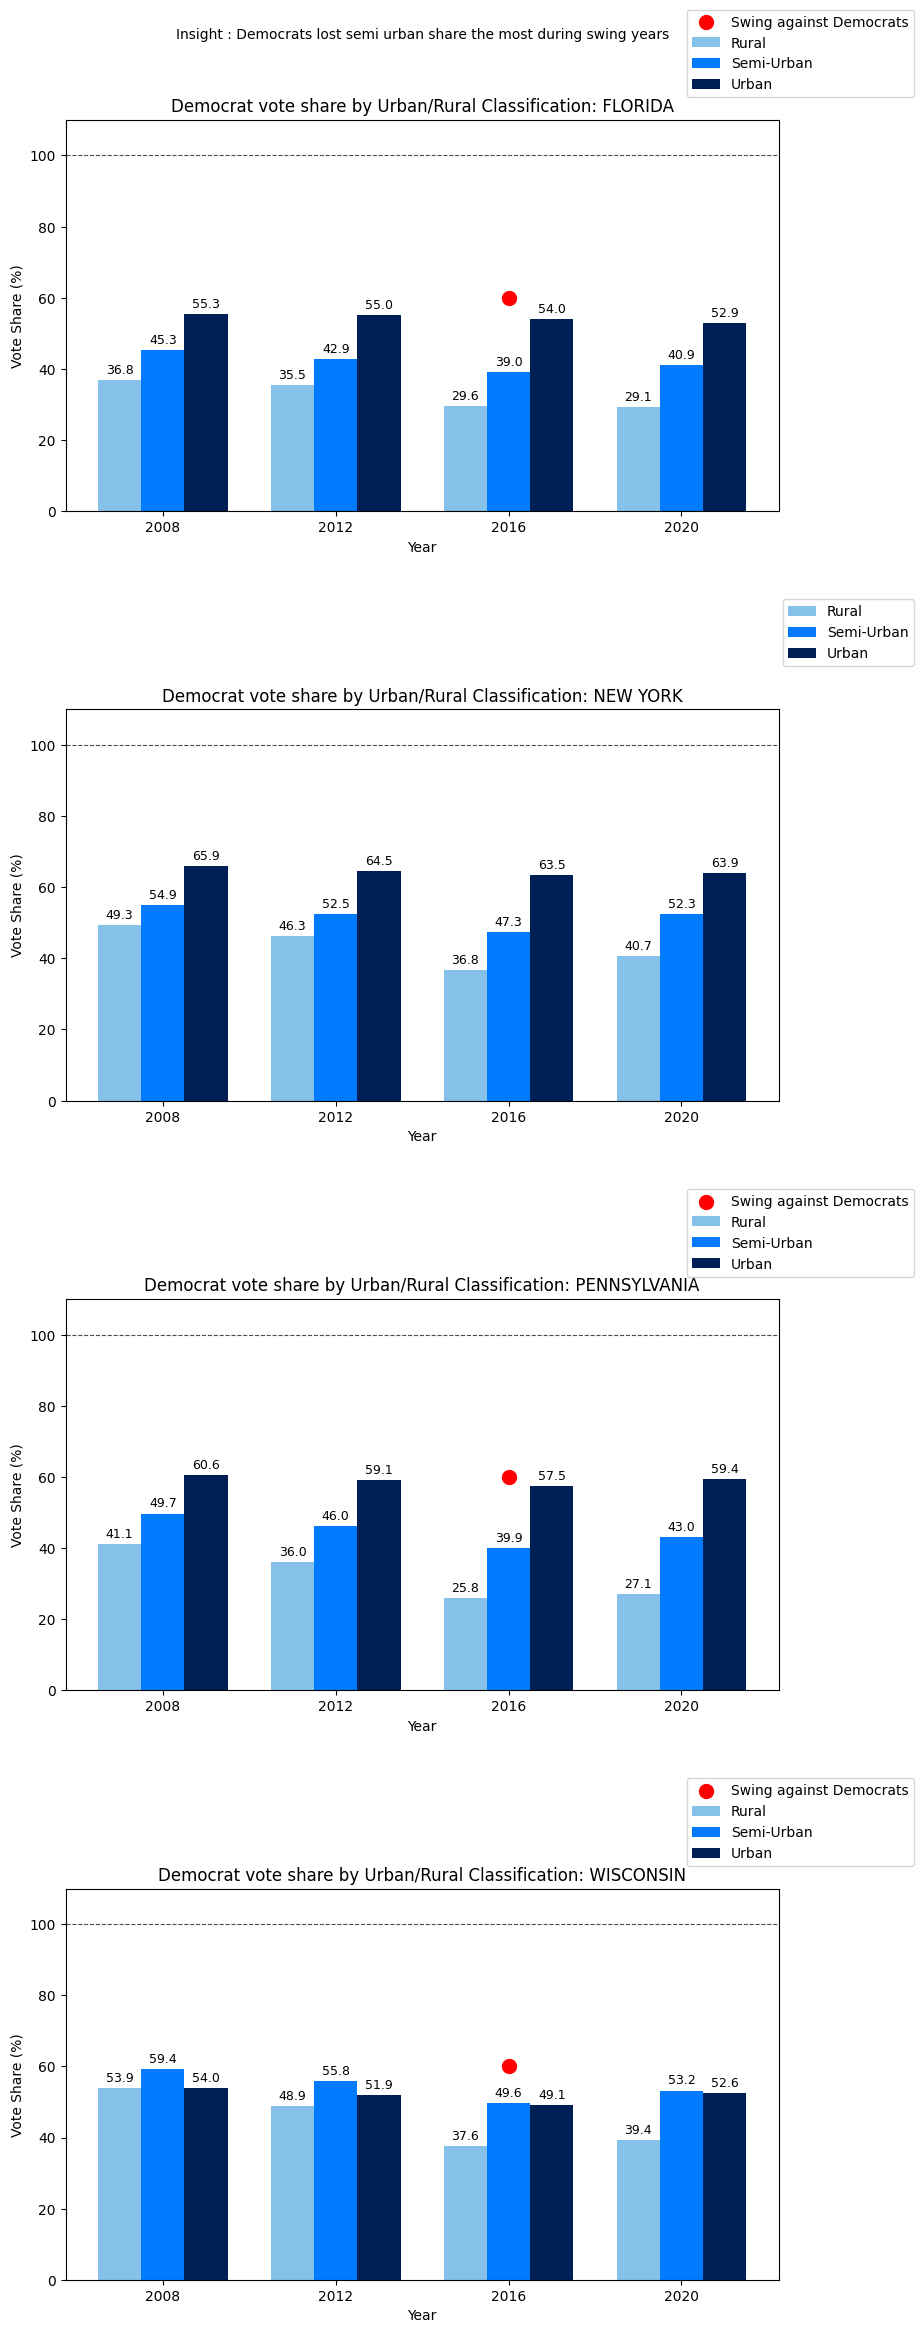

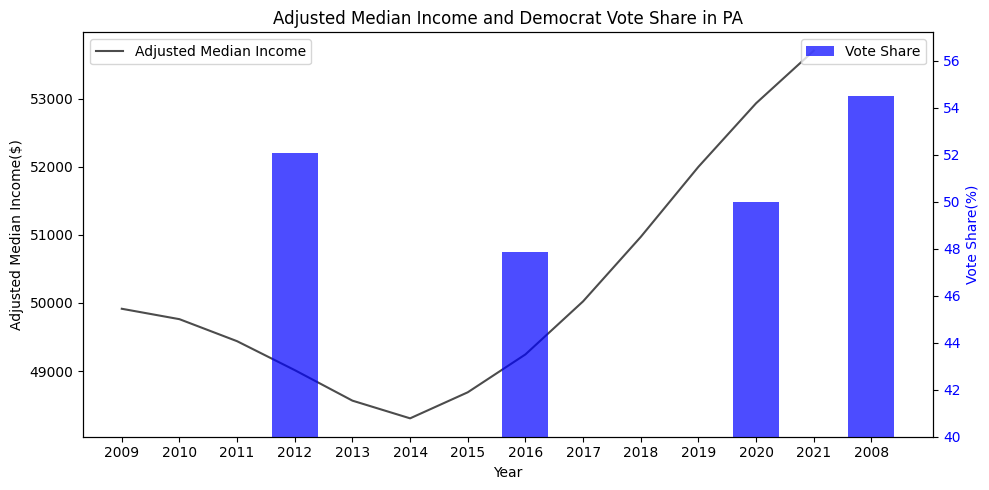

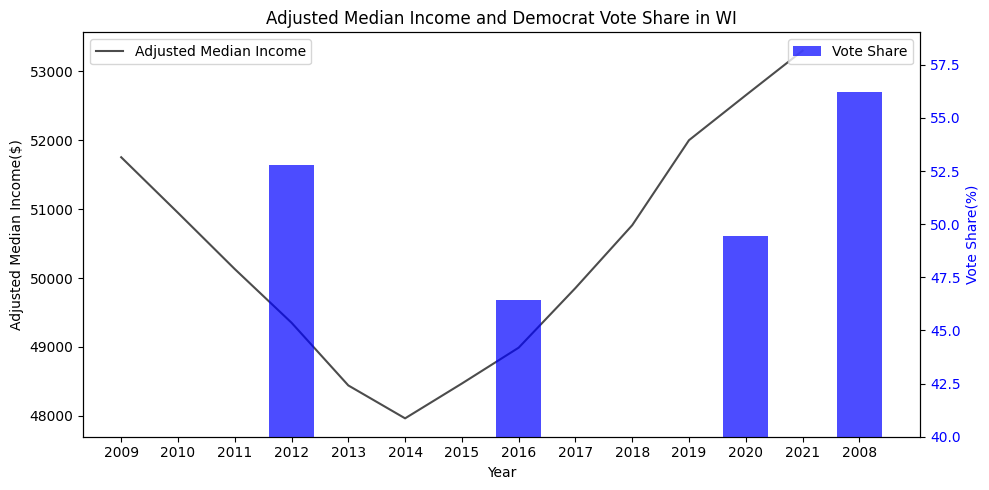

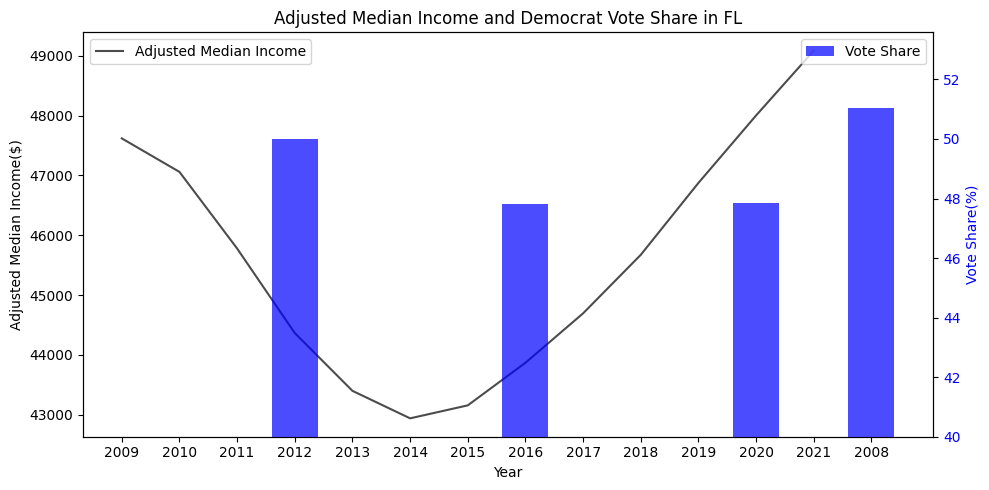

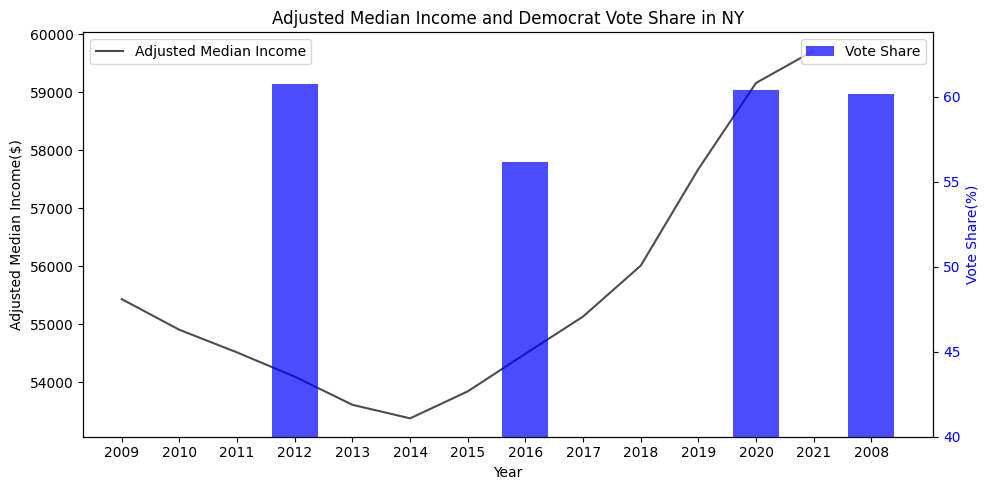

In [16]:
if __name__ == "__main__":
    main()

In [17]:
# test comment


Key Takeaways -

Rural / Urban divide

*   Democrats have majority voteshare in urban-areas
*   In the election year where democrats lose - they lose their max voteshare in semi-urban ( and note losing in semi-urban matters - WI has like a 50 percent semi-urban / rural voters)
*   Strongly democrat states like WA and NY have steady urban voteshare

Economic indeicators


*   Lagged relationship - lose voteshare not immediately but subsequently with declining HHI





